<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [What Is Machine Learning?](05.01-What-Is-Machine-Learning.ipynb) | [Contents](Index.ipynb) | [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) >

# Introducing Scikit-Learn

There are several Python libraries which provide solid implementations of a range of machine learning algorithms.
One of the best known is [Scikit-Learn](http://scikit-learn.org), a package that provides efficient versions of a large number of common algorithms.
Scikit-Learn is characterized by a clean, uniform, and streamlined API, as well as by very useful and complete online documentation.
A benefit of this uniformity is that once you understand the basic use and syntax of Scikit-Learn for one type of model, switching to a new model or algorithm is very straightforward.

This section provides an overview of the Scikit-Learn API; a solid understanding of these API elements will form the foundation for understanding the deeper practical discussion of machine learning algorithms and approaches in the following chapters.

We will start by covering *data representation* in Scikit-Learn, followed by covering the *Estimator* API, and finally go through a more interesting example of using these tools for exploring a set of images of hand-written digits.

## Data Representation in Scikit-Learn

Machine learning is about creating models from data: for that reason, we'll start by discussing how data can be represented in order to be understood by the computer.
The best way to think about data within Scikit-Learn is in terms of tables of data.

### Data as table

A basic table is a two-dimensional grid of data, in which the rows represent individual elements of the dataset, and the columns represent quantities related to each of these elements.
For example, consider the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), famously analyzed by Ronald Fisher in 1936.
We can download this dataset in the form of a Pandas ``DataFrame`` using the [seaborn](http://seaborn.pydata.org/) library:

In [1]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Here each row of the data refers to a single observed flower, and the number of rows is the total number of flowers in the dataset.
In general, we will refer to the rows of the matrix as *samples*, and the number of rows as ``n_samples``.

Likewise, each column of the data refers to a particular quantitative piece of information that describes each sample.
In general, we will refer to the columns of the matrix as *features*, and the number of columns as ``n_features``.

#### Features matrix

This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, which we will call the *features matrix*.
By convention, this features matrix is often stored in a variable named ``X``.
The features matrix is assumed to be two-dimensional, with shape ``[n_samples, n_features]``, and is most often contained in a NumPy array or a Pandas ``DataFrame``, though some Scikit-Learn models also accept SciPy sparse matrices.

The samples (i.e., rows) always refer to the individual objects described by the dataset.
For example, the sample might be a flower, a person, a document, an image, a sound file, a video, an astronomical object, or anything else you can describe with a set of quantitative measurements.

The features (i.e., columns) always refer to the distinct observations that describe each sample in a quantitative manner.
Features are generally real-valued, but may be Boolean or discrete-valued in some cases.

#### Target array

In addition to the feature matrix ``X``, we also generally work with a *label* or *target* array, which by convention we will usually call ``y``.
The target array is usually one dimensional, with length ``n_samples``, and is generally contained in a NumPy array or Pandas ``Series``.
The target array may have continuous numerical values, or discrete classes/labels.
While some Scikit-Learn estimators do handle multiple target values in the form of a two-dimensional, ``[n_samples, n_targets]`` target array, we will primarily be working with the common case of a one-dimensional target array.

Often one point of confusion is how the target array differs from the other features columns. The distinguishing feature of the target array is that it is usually the quantity we want to *predict from the data*: in statistical terms, it is the dependent variable.
For example, in the preceding data we may wish to construct a model that can predict the species of flower based on the other measurements; in this case, the ``species`` column would be considered the target array.

With this target array in mind, we can use Seaborn (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)) to conveniently visualize the data:

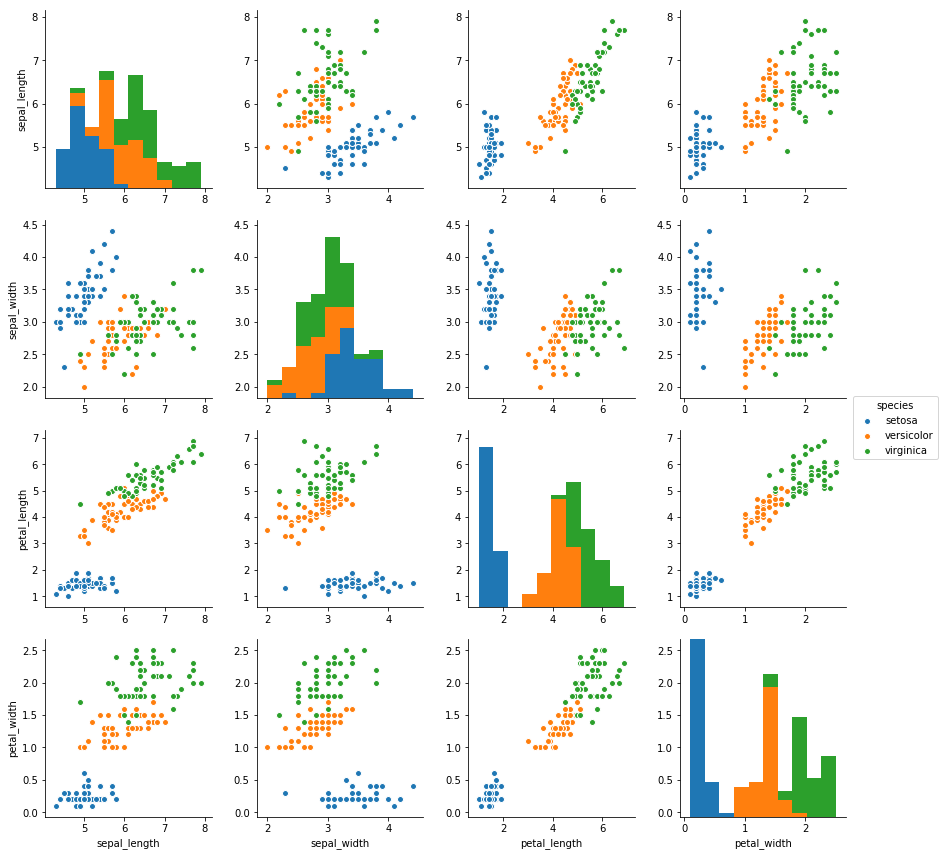

In [4]:
%matplotlib inline
import seaborn as sns
sns.pairplot(iris, hue='species', size=3);

For use in Scikit-Learn, we will extract the features matrix and target array from the ``DataFrame``, which we can do using some of the Pandas ``DataFrame`` operations discussed in the [Chapter 3](03.00-Introduction-to-Pandas.ipynb):

In [5]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [6]:
y_iris = iris['species']
y_iris.shape

(150,)

To summarize, the expected layout of features and target values is visualized in the following diagram:

![](figures/05.02-samples-features.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Features-and-Labels-Grid)

With this data properly formatted, we can move on to consider the *estimator* API of Scikit-Learn:

## Scikit-Learn's Estimator API

The Scikit-Learn API is designed with the following guiding principles in mind, as outlined in the [Scikit-Learn API paper](http://arxiv.org/abs/1309.0238):

- *Consistency*: All objects share a common interface drawn from a limited set of methods, with consistent documentation.

- *Inspection*: All specified parameter values are exposed as public attributes.

- *Limited object hierarchy*: Only algorithms are represented by Python classes; datasets are represented
  in standard formats (NumPy arrays, Pandas ``DataFrame``s, SciPy sparse matrices) and parameter
  names use standard Python strings.

- *Composition*: Many machine learning tasks can be expressed as sequences of more fundamental algorithms,
  and Scikit-Learn makes use of this wherever possible.

- *Sensible defaults*: When models require user-specified parameters, the library defines an appropriate default value.

In practice, these principles make Scikit-Learn very easy to use, once the basic principles are understood.
Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.

### Basics of the API

Most commonly, the steps in using the Scikit-Learn estimator API are as follows
(we will step through a handful of detailed examples in the sections that follow).

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

We will now step through several simple examples of applying supervised and unsupervised learning methods.

### Supervised learning example: Simple linear regression

As an example of this process, let's consider a simple linear regression—that is, the common case of fitting a line to $(x, y)$ data.
We will use the following simple data for our regression example:

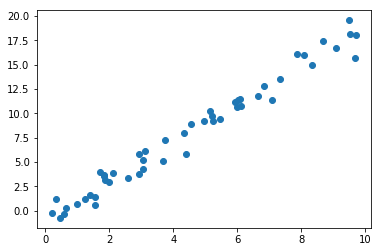

In [7]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = 2 * x - 1 + rng.randn(50)
plt.scatter(x, y);

With this data in place, we can use the recipe outlined earlier. Let's walk through the process: 

#### 1. Choose a class of model

In Scikit-Learn, every class of model is represented by a Python class.
So, for example, if we would like to compute a simple linear regression model, we can import the linear regression class:

In [8]:
from sklearn.linear_model import LinearRegression

Note that other more general linear regression models exist as well; you can read more about them in the [``sklearn.linear_model`` module documentation](http://Scikit-Learn.org/stable/modules/linear_model.html).

#### 2. Choose model hyperparameters

An important point is that *a class of model is not the same as an instance of a model*.

Once we have decided on our model class, there are still some options open to us.
Depending on the model class we are working with, we might need to answer one or more questions like the following:

- Would we like to fit for the offset (i.e., *y*-intercept)?
- Would we like the model to be normalized?
- Would we like to preprocess our features to add model flexibility?
- What degree of regularization would we like to use in our model?
- How many model components would we like to use?

These are examples of the important choices that must be made *once the model class is selected*.
These choices are often represented as *hyperparameters*, or parameters that must be set before the model is fit to data.
In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation.
We will explore how you can quantitatively motivate the choice of hyperparameters in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb).

For our linear regression example, we can instantiate the ``LinearRegression`` class and specify that we would like to fit the intercept using the ``fit_intercept`` hyperparameter:

In [9]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Keep in mind that when the model is instantiated, the only action is the storing of these hyperparameter values.
In particular, we have not yet applied the model to any data: the Scikit-Learn API makes very clear the distinction between *choice of model* and *application of model to data*.

#### 3. Arrange data into a features matrix and target vector

Previously we detailed the Scikit-Learn data representation, which requires a two-dimensional features matrix and a one-dimensional target array.
Here our target variable ``y`` is already in the correct form (a length-``n_samples`` array), but we need to massage the data ``x`` to make it a matrix of size ``[n_samples, n_features]``.
In this case, this amounts to a simple reshaping of the one-dimensional array:

In [10]:
X = x[:, np.newaxis]
X.shape

(50, 1)

#### 4. Fit the model to your data

Now it is time to apply our model to data.
This can be done with the ``fit()`` method of the model:

In [11]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

This ``fit()`` command causes a number of model-dependent internal computations to take place, and the results of these computations are stored in model-specific attributes that the user can explore.
In Scikit-Learn, by convention all model parameters that were learned during the ``fit()`` process have trailing underscores; for example in this linear model, we have the following:

In [12]:
model.coef_

array([1.9776566])

In [13]:
model.intercept_

-0.9033107255311164

These two parameters represent the slope and intercept of the simple linear fit to the data.
Comparing to the data definition, we see that they are very close to the input slope of 2 and intercept of -1.

One question that frequently comes up regards the uncertainty in such internal model parameters.
In general, Scikit-Learn does not provide tools to draw conclusions from internal model parameters themselves: interpreting model parameters is much more a *statistical modeling* question than a *machine learning* question.
Machine learning rather focuses on what the model *predicts*.
If you would like to dive into the meaning of fit parameters within the model, other tools are available, including the [Statsmodels Python package](http://statsmodels.sourceforge.net/).

#### 5. Predict labels for unknown data

Once the model is trained, the main task of supervised machine learning is to evaluate it based on what it says about new data that was not part of the training set.
In Scikit-Learn, this can be done using the ``predict()`` method.
For the sake of this example, our "new data" will be a grid of *x* values, and we will ask what *y* values the model predicts:

In [14]:
xfit = np.linspace(-1, 11)

As before, we need to coerce these *x* values into a ``[n_samples, n_features]`` features matrix, after which we can feed it to the model:

In [15]:
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

Finally, let's visualize the results by plotting first the raw data, and then this model fit:

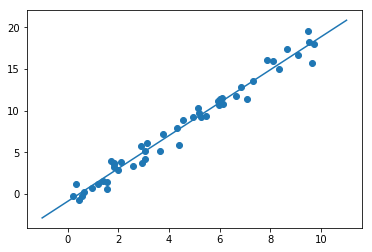

In [16]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

Typically the efficacy of the model is evaluated by comparing its results to some known baseline, as we will see in the next example

### Supervised learning example: Iris classification

Let's take a look at another example of this process, using the Iris dataset we discussed earlier.
Our question will be this: given a model trained on a portion of the Iris data, how well can we predict the remaining labels?

For this task, we will use an extremely simple generative model known as Gaussian naive Bayes, which proceeds by assuming each class is drawn from an axis-aligned Gaussian distribution (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) for more details).
Because it is so fast and has no hyperparameters to choose, Gaussian naive Bayes is often a good model to use as a baseline classification, before exploring whether improvements can be found through more sophisticated models.

We would like to evaluate the model on data it has not seen before, and so we will split the data into a *training set* and a *testing set*.
This could be done by hand, but it is more convenient to use the ``train_test_split`` utility function:

In [17]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris,
                                                random_state=1)

With the data arranged, we can follow our recipe to predict the labels:

In [18]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

Finally, we can use the ``accuracy_score`` utility to see the fraction of predicted labels that match their true value:

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9736842105263158

With an accuracy topping 97%, we see that even this very naive classification algorithm is effective for this particular dataset!

### Unsupervised learning example: Iris dimensionality

As an example of an unsupervised learning problem, let's take a look at reducing the dimensionality of the Iris data so as to more easily visualize it.
Recall that the Iris data is four dimensional: there are four features recorded for each sample.

The task of dimensionality reduction is to ask whether there is a suitable lower-dimensional representation that retains the essential features of the data.
Often dimensionality reduction is used as an aid to visualizing data: after all, it is much easier to plot data in two dimensions than in four dimensions or higher!

Here we will use principal component analysis (PCA; see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), which is a fast linear dimensionality reduction technique.
We will ask the model to return two components—that is, a two-dimensional representation of the data.

Following the sequence of steps outlined earlier, we have:

In [20]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X_iris)         # 4. Transform the data to two dimensions

Now let's plot the results. A quick way to do this is to insert the results into the original Iris ``DataFrame``, and use Seaborn's ``lmplot`` to show the results:

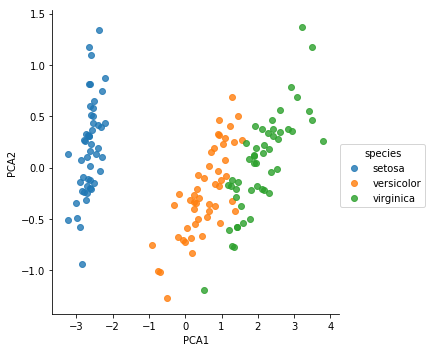

In [21]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='species', data=iris, fit_reg=False);

We see that in the two-dimensional representation, the species are fairly well separated, even though the PCA algorithm had no knowledge of the species labels!
This indicates to us that a relatively straightforward classification will probably be effective on the dataset, as we saw before.

### Unsupervised learning: Iris clustering

Let's next look at applying clustering to the Iris data.
A clustering algorithm attempts to find distinct groups of data without reference to any labels.
Here we will use a powerful clustering method called a Gaussian mixture model (GMM), discussed in more detail in [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb).
A GMM attempts to model the data as a collection of Gaussian blobs.

We can fit the Gaussian mixture model as follows:

In [22]:
from sklearn.mixture import GaussianMixture      # 1. Choose the model class
model = GaussianMixture(n_components=3,
            covariance_type='full')  # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                    # 3. Fit to data. Notice y is not specified!
y_gmm = model.predict(X_iris)        # 4. Determine cluster labels

As before, we will add the cluster label to the Iris ``DataFrame`` and use Seaborn to plot the results:

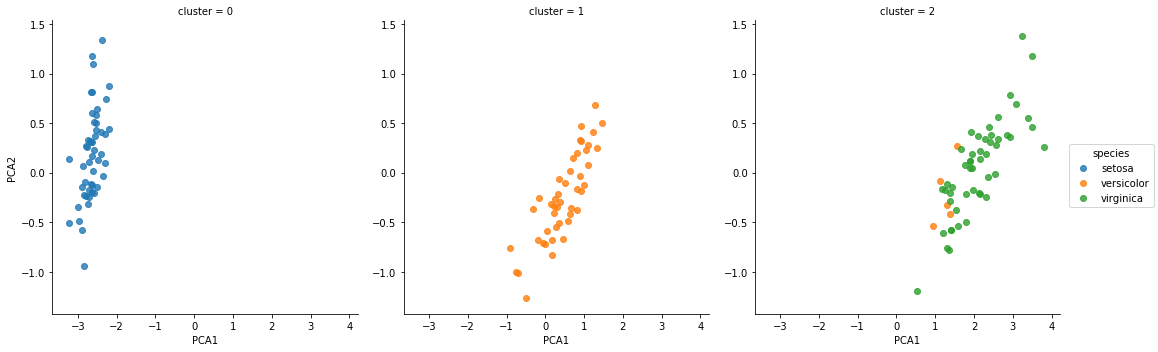

In [23]:
iris['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=iris, hue='species',
           col='cluster', fit_reg=False);

By splitting the data by cluster number, we see exactly how well the GMM algorithm has recovered the underlying label: the *setosa* species is separated perfectly within cluster 0, while there remains a small amount of mixing between *versicolor* and *virginica*.
This means that even without an expert to tell us the species labels of the individual flowers, the measurements of these flowers are distinct enough that we could *automatically* identify the presence of these different groups of species with a simple clustering algorithm!
This sort of algorithm might further give experts in the field clues as to the relationship between the samples they are observing.

## Application: Exploring Hand-written Digits

To demonstrate these principles on a more interesting problem, let's consider one piece of the optical character recognition problem: the identification of hand-written digits.
In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use Scikit-Learn's set of pre-formatted digits, which is built into the library.

### Loading and visualizing the digits data

We'll use Scikit-Learn's data access interface and take a look at this data:

In [24]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples each consisting of an 8 × 8 grid of pixels.
Let's visualize the first hundred of these:

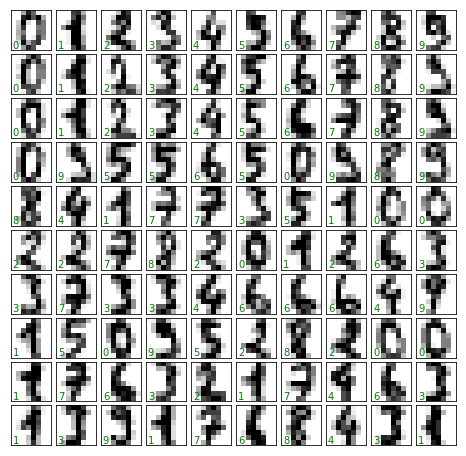

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, ``[n_samples, n_features]`` representation.
We can accomplish this by treating each pixel in the image as a feature: that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit.
Additionally, we need the target array, which gives the previously determined label for each digit.
These two quantities are built into the digits dataset under the ``data`` and ``target`` attributes, respectively:

In [26]:
X = digits.data
X.shape

(1797, 64)

In [27]:
y = digits.target
y.shape

(1797,)

We see here that there are 1,797 samples and 64 features.

### Unsupervised learning: Dimensionality reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to effectively visualize points in such a high-dimensional space.
Instead we'll reduce the dimensions to 2, using an unsupervised method.
Here, we'll make use of a manifold learning algorithm called *Isomap* (see [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)), and transform the data to two dimensions:

In [28]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

We see that the projected data is now two-dimensional.
Let's plot this data to see if we can learn anything from its structure:

/home/sergey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


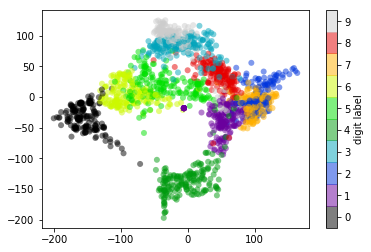

In [29]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

This plot gives us some good intuition into how well various numbers are separated in the larger 64-dimensional space. For example, zeros (in black) and ones (in purple) have very little overlap in parameter space.
Intuitively, this makes sense: a zero is empty in the middle of the image, while a one will generally have ink in the middle.
On the other hand, there seems to be a more or less continuous spectrum between ones and fours: we can understand this by realizing that some people draw ones with "hats" on them, which cause them to look similar to fours.

Overall, however, the different groups appear to be fairly well separated in the parameter space: this tells us that even a very straightforward supervised classification algorithm should perform suitably on this data.
Let's give it a try.

### Classification on digits

Let's apply a classification algorithm to the digits.
As with the Iris data previously, we will split the data into a training and testing set, and fit a Gaussian naive Bayes model:

In [30]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [31]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Now that we have predicted our model, we can gauge its accuracy by comparing the true values of the test set to the predictions:

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

With even this extremely simple model, we find about 80% accuracy for classification of the digits!
However, this single number doesn't tell us *where* we've gone wrong—one nice way to do this is to use the *confusion matrix*, which we can compute with Scikit-Learn and plot with Seaborn:

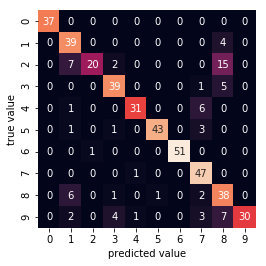

In [33]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

This shows us where the mis-labeled points tend to be: for example, a large number of twos here are mis-classified as either ones or eights.
Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels.
We'll use green for correct labels, and red for incorrect labels:

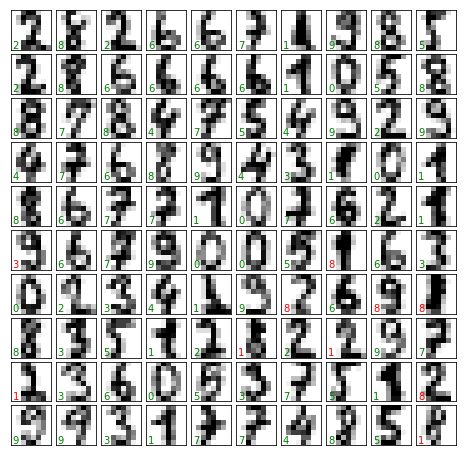

In [34]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

Examining this subset of the data, we can gain insight regarding where the algorithm might be not performing optimally.
To go beyond our 80% classification rate, we might move to a more sophisticated algorithm such as support vector machines (see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)), random forests (see [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb)) or another classification approach.

## Summary

In this section we have covered the essential features of the Scikit-Learn data representation, and the estimator API.
Regardless of the type of estimator, the same import/instantiate/fit/predict pattern holds.
Armed with this information about the estimator API, you can explore the Scikit-Learn documentation and begin trying out various models on your data.

In the next section, we will explore perhaps the most important topic in machine learning: how to select and validate your model.

<!--NAVIGATION-->
< [What Is Machine Learning?](05.01-What-Is-Machine-Learning.ipynb) | [Contents](Index.ipynb) | [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) >